In [1]:
import sys
import json
from tqdm import tqdm

import torchaudio
import torch

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('beats_model/unilm/beats/')

import torch
from Tokenizers import TokenizersConfig, Tokenizers

# load the pre-trained checkpoints
checkpoint = torch.load('beats_model/Tokenizer_iter3_plus_AS2M.pt')

cfg = TokenizersConfig(checkpoint['cfg'])
BEATs_tokenizer = Tokenizers(cfg)
BEATs_tokenizer.load_state_dict(checkpoint['model']) #load weights
BEATs_tokenizer.eval()

# tokenize the audio and generate the labels
audio_input_16khz = torch.randn(1, 10000)
padding_mask = torch.zeros(1, 10000).bool()

labels = BEATs_tokenizer.extract_labels(audio_input_16khz, padding_mask=padding_mask) #tokenize random audio input

/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [2]:
import torch
from BEATs import BEATs, BEATsConfig

# load the pre-trained checkpoints
checkpoint = torch.load('beats_model/BEATs_iter3_plus_AS2M.pt')

cfg = BEATsConfig(checkpoint['cfg']) #config for model architecture
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model']) #load model weights
BEATs_model.eval()

# extract the the audio representation
audio_input_16khz = torch.randn(1, 10000)
padding_mask = torch.zeros(1, 10000).bool()

representation = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0] #get final layer audio features from rand audio

In [3]:
#dont run for feature extraction
import torch
from BEATs import BEATs, BEATsConfig

# load the fine-tuned checkpoints
checkpoint = torch.load('beats_model/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt') #classification model

cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()

# predict the classification probability of each class
audio_input_16khz = torch.randn(3, 10000) #3 rand audios batch
padding_mask = torch.zeros(3, 10000).bool()

probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0] #classification probs for each audio

#prints raw ids
for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=5))): #top 5 predicted classes for eahc audio and probs
    top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]#class names from label_dict
    print(f'Top 5 predicted labels of the {i}th audio are {top5_label} with probability of {top5_label_prob}')

Top 5 predicted labels of the 0th audio are ['/m/07rgkc5', '/m/0chx_', '/m/09x0r', '/m/096m7z', '/m/07qlf79'] with probability of tensor([0.2851, 0.1603, 0.1547, 0.1278, 0.0467], grad_fn=<UnbindBackward0>)
Top 5 predicted labels of the 1th audio are ['/m/07rgkc5', '/m/09x0r', '/m/0chx_', '/m/096m7z', '/m/0cj0r'] with probability of tensor([0.2293, 0.2038, 0.1629, 0.1511, 0.0409], grad_fn=<UnbindBackward0>)
Top 5 predicted labels of the 2th audio are ['/m/07rgkc5', '/m/0chx_', '/m/09x0r', '/m/096m7z', '/m/0cj0r'] with probability of tensor([0.2256, 0.1552, 0.1496, 0.0777, 0.0540], grad_fn=<UnbindBackward0>)


## Sample on one Movie

In [4]:
# Load the audio file
waveform, sample_rate = torchaudio.load("7T_MOVIE1_CC1_v2.wav") #waveform = raw audio data tensor

# Resample if the sampling rate is not 16kHz
if sample_rate != 16000:
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000) #beats uses 16khz sampling rate
    waveform = resample_transform(waveform)

# Convert to mono if necessary
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True) #1 channel

LibsndfileError: Error opening '7T_MOVIE1_CC1_v2.wav': System error.

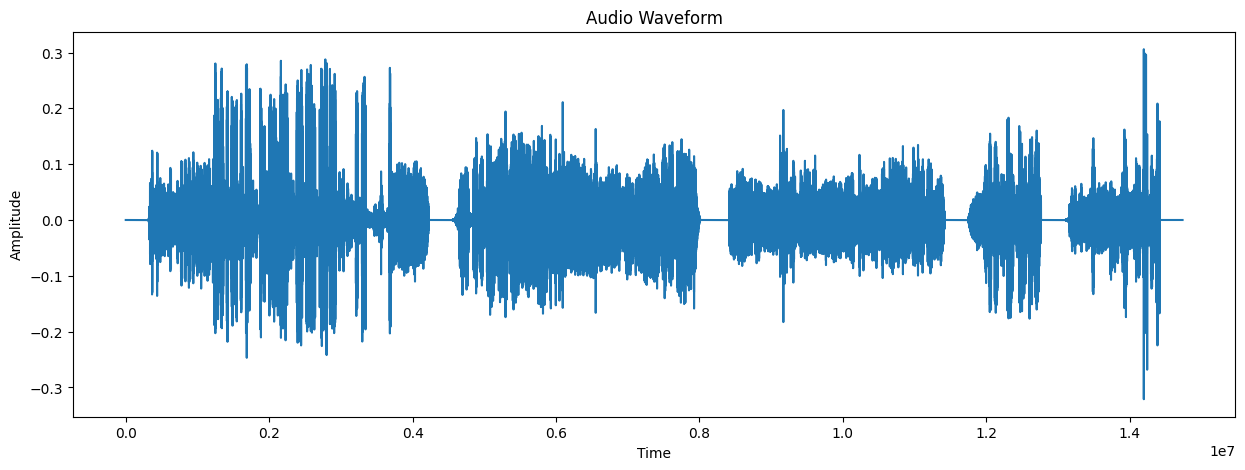

In [ ]:
# plot waveform
plt.figure(figsize=(15, 5))
plt.plot(waveform.t().numpy())
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [93]:
waveform.shape
# Split the audio into chunks of 5 seconds
chunk_duration = 5  # seconds
chunk_samples = chunk_duration * 16000  # number of samples in each chunk
chunk_step = 1 * 16000  # step size for each chunk -> 1 sec, 16000 samples - overlap
chunks = []
for start in range(0, waveform.shape[1], chunk_step):
    end = min(start + chunk_samples, waveform.shape[1]) #start at start, end at start+chunk_samples
    chunk = waveform[:, start:end]
    if chunk.shape[1] == chunk_samples:
        chunks.append(chunk)
    else:
        # Pad the last chunk with zeros if it's shorter than 10 seconds
        padding = torch.zeros(1, chunk_samples - chunk.shape[1])
        chunk = torch.cat((chunk, padding), dim=1)
        chunks.append(chunk)
chunks = torch.cat(chunks, dim=0)
chunks.shape #(num chunks, chunk samples)
# chunks = chunks.unsqueeze(0)  # Add batch dimension
print(chunks.shape)
# Create a padding mask for the chunks
padding_mask = torch.zeros(chunks.shape[0], chunks.shape[1]).bool()
# The padding mask is all zeros since we don't have any padding in this case

torch.Size([922, 80000])


In [94]:

# Example: using a BEATs model instance named `beat_model`
BEATs_model.eval()  # set the model to evaluation mode
with torch.no_grad():
    probs =  BEATs_model.extract_features(chunks, padding_mask=padding_mask)[0] #pass audio inpnut chunks thru model, class probs


In [95]:
probs.shape

torch.Size([922, 527])

In [ ]:
# Load ontology json
with open('beats_model/ontology.json', 'r') as f:
    ontology = json.load(f) #maps raw ids to readable format

In [97]:
# Open subtitle.srt file to write
probs_keep = []
with open('subtitle.srt', 'w') as f:
    for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=5))):#each chunk get top 5 label idx and probs
        top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx] #label idx -> raw id
        probs_keep.append(top5_label_prob)
        # Find ids in the ontology and get the corresponding labels
        top5_names = []
        for name in top5_label:
            name = [item['name'] for item in ontology if item['id'] == name]
            top5_names.append(name)
        print(f'{i*chunk_duration} ==> {(i+1)*chunk_duration} ::: Labels {top5_names}')
        f.write(f'{i+1}\n')
        # Write the start and end time of the chunk in 00:00:00,000 --> 00:00:00,000 format
        start_time = i * chunk_duration
        end_time = (i + 1) * chunk_duration
        start_time_str = f'{int(start_time // 3600):02}:{int((start_time % 3600) // 60):02}:{int(start_time % 60):02},000'
        end_time_str = f'{int(end_time // 3600):02}:{int((end_time % 3600) // 60):02}:{int(end_time % 60):02},000'
        f.write(f'{start_time_str} --> {end_time_str}\n')
        f.write(f'{top5_names}\n\n')

f.close()

0 ==> 5 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
5 ==> 10 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
10 ==> 15 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
15 ==> 20 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
20 ==> 25 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
25 ==> 30 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
30 ==> 35 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
35 ==> 40 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
40 ==> 45 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
45 ==> 50 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water vehicle']]
50 ==> 55 ::: Labels [['Music'], ['Vehicle'], ['Speech'], ['Car'], ['Boat, Water ve

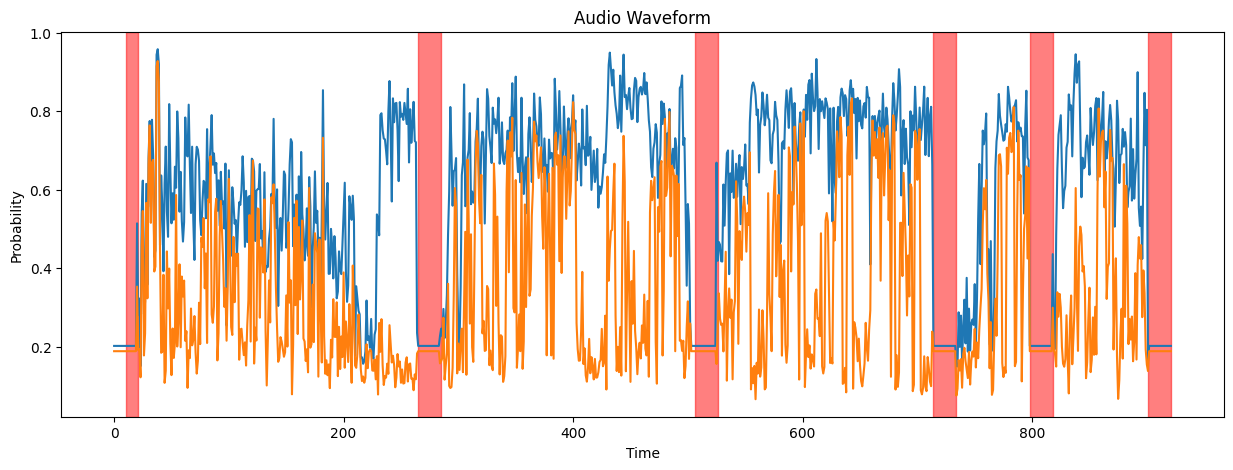

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(probs_keep)[:,[0,1]])
# plt.plot(np.max(probs_keep, axis=1))
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Probability")

# Higlight fixation points
# Fixation = [10:21+10 265:285+10 506:526+10 714:734+10 798:818+10 901:921];
fixation = [10, 21, 265, 285, 506, 526, 714, 734, 798, 818, 901, 921] #highlighted sections start and end idxs
for i in range(0,len(fixation),2):
    plt.axvspan(fixation[i], fixation[i+1], color='red', alpha=0.5)

#plot highest and 2nd highest class confidence
plt.show()


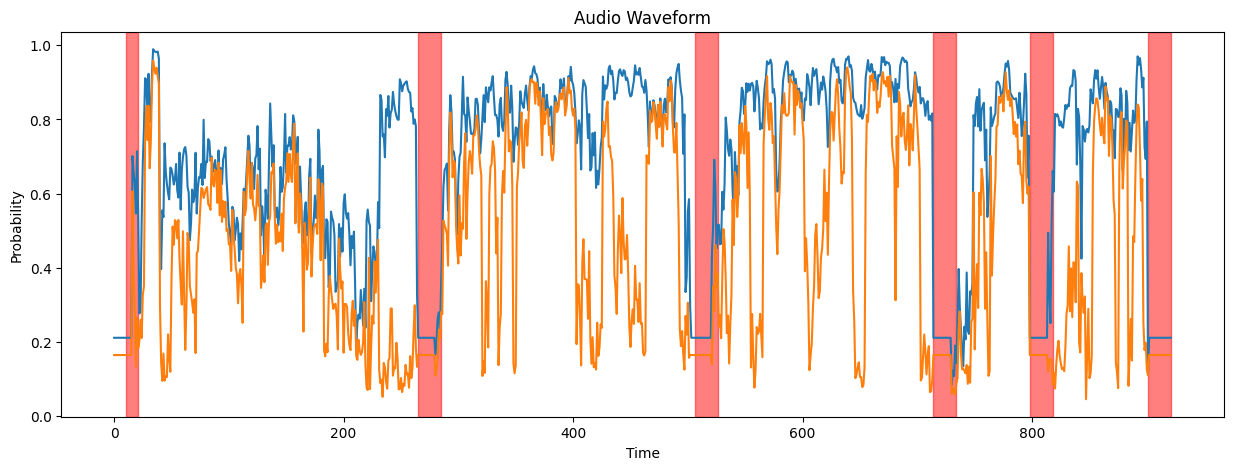

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(probs_keep)[:,[0,1]])
# plt.plot(np.max(probs_keep, axis=1))
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Probability")

# Higlight fixation points
# Fixation = [10:21+10 265:285+10 506:526+10 714:734+10 798:818+10 901:921];
fixation = [10, 21, 265, 285, 506, 526, 714, 734, 798, 818, 901, 921]
for i in range(0,len(fixation),2):
    plt.axvspan(fixation[i], fixation[i+1], color='red', alpha=0.5)
plt.show()


## Label All 4 Movies

In [9]:
Names = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
Time = [0, 921, 921+918, 921+918+915, 921+918+915+901]
chunk_duration = 1  # seconds
chunk_samples = chunk_duration * 16000  # number of samples in each chunk
chunk_step = 1 * 16000  # step size for each chunk
threshold = 0.25;

with open('beats_model/ontology.json', 'r') as f:
    ontology = json.load(f)

with open(f'subtitle_merged.srt', 'w') as f_m:
    probs_keep_all = []
    top5_names_all = []
    for iter_num, name in tqdm(enumerate(Names)):
        # Load the audio file
        waveform, sample_rate = torchaudio.load(f"{name}.wav")

        # Resample if the sampling rate is not 16kHz
        if sample_rate != 16000:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resample_transform(waveform)

        # Convert to mono if necessary
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Split the audio into chunks
        chunks = []
        for start in range(0, waveform.shape[1], chunk_step):
            end = min(start + chunk_samples, waveform.shape[1])
            chunk = waveform[:, start:end]
            if chunk.shape[1] == chunk_samples:
                chunks.append(chunk)
            else:
                # Pad the last chunk with zeros if it's shorter than 10 seconds
                padding = torch.zeros(1, chunk_samples - chunk.shape[1])
                chunk = torch.cat((chunk, padding), dim=1)
                # chunks.append(chunk)
        chunks = torch.cat(chunks, dim=0)
        padding_mask = torch.zeros(chunks.shape[0], chunks.shape[1]).bool()

        BEATs_model.eval()  # set the model to evaluation mode
        with torch.no_grad():
            probs =  BEATs_model.extract_features(chunks, padding_mask=padding_mask)[0]

        # Open subtitle.srt file to write
        probs_keep = []
        top5_keep = []
        with open(f'{name}.srt', 'w') as f:
            for i, (top5_label_prob, top5_label_idx) in tqdm(enumerate(zip(*probs.topk(k=5)))):
                top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
                probs_keep.append(top5_label_prob)
                # Find ids in the ontology and get the corresponding labels
                top5_names = []
                for ind, name in enumerate(top5_label):
                    if top5_label_prob[ind] < threshold:
                        continue
                    name = [item['name'] for item in ontology if item['id'] == name]
                    top5_names.append(name)
                # print(f'{i*chunk_duration} ==> {(i+1)*chunk_duration} ::: Labels {top5_names}')
                top5_keep.append(top5_names)
                f.write(f'{i+1}\n')
                # Write the start and end time of the chunk in 00:00:00,000 --> 00:00:00,000 format
                start_time = i * chunk_duration
                end_time = (i + 1) * chunk_duration
                start_time_str = f'{int(start_time // 3600):02}:{int((start_time % 3600) // 60):02}:{int(start_time % 60):02},000'
                end_time_str = f'{int(end_time // 3600):02}:{int((end_time % 3600) // 60):02}:{int(end_time % 60):02},000'
                f.write(f'{start_time_str} --> {end_time_str}\n')
                f.write(f'{top5_names}\n\n')

                f_m.write(f'{i+Time[iter_num]+1}\n')
                start_time = start_time + Time[iter_num]
                end_time = end_time + Time[iter_num]
                start_time_str = f'{int(start_time // 3600):02}:{int((start_time % 3600) // 60):02}:{int(start_time % 60):02},000'
                end_time_str = f'{int(end_time // 3600):02}:{int((end_time % 3600) // 60):02}:{int(end_time % 60):02},000'
                f_m.write(f'{start_time_str} --> {end_time_str}\n')
                f_m.write(f'{top5_names}\n\n')

        f.close()
        probs_keep_all.append(probs_keep)
        top5_names_all.append(top5_keep)
f_m.close()

921it [00:00, 24955.29it/s]
918it [00:00, 26465.94it/s]
915it [00:00, 26196.15it/s]
901it [00:00, 26099.98it/s]
4it [00:34,  8.68s/it]


In [10]:
# Fixation = [10:21+10 265:285+10 506:526+10 714:734+10 798:818+10 901:921 921+[1:21+10 247:267+10 526:546+10 795:815+10 898:918] ...
#             921+918+[1:21+10 201:221+10 406:426+10 630:650+10 792:812+10 895:915] 921+918+915+[1:21+10 253:273+10 503:523+10 778:798+10 881:901]];
fixation = [10, 21, 265, 285, 506, 526, 714, 734, 798, 818, 901, 921,
            921+1, 921+21, 921+247, 921+267, 921+526, 921+546, 921+795, 921+815, 921+898, 921+918,
            921+918+1, 921+918+21, 921+918+201, 921+918+221, 921+918+406, 921+918+426, 921+918+630, 921+918+650,
            921+918+792, 921+918+812, 921+918+895, 921+918+915,
            921+918+915+1, 921+918+915+21, 921+918+915+253, 921+918+915+273, 921+918+915+503, 921+918+915+523,
            921+918+915+778, 921+918+915+798, 921+918+915+881, 921+918+915+901]

max(fixation)

3655

In [11]:
probs_keep_all = probs_keep_all[0] + probs_keep_all[1] + probs_keep_all[2] + probs_keep_all[3]
len(probs_keep_all)

3655

In [12]:
top5_names_all = top5_names_all[0] + top5_names_all[1] + top5_names_all[2] + top5_names_all[3]
len(top5_names_all)

3655

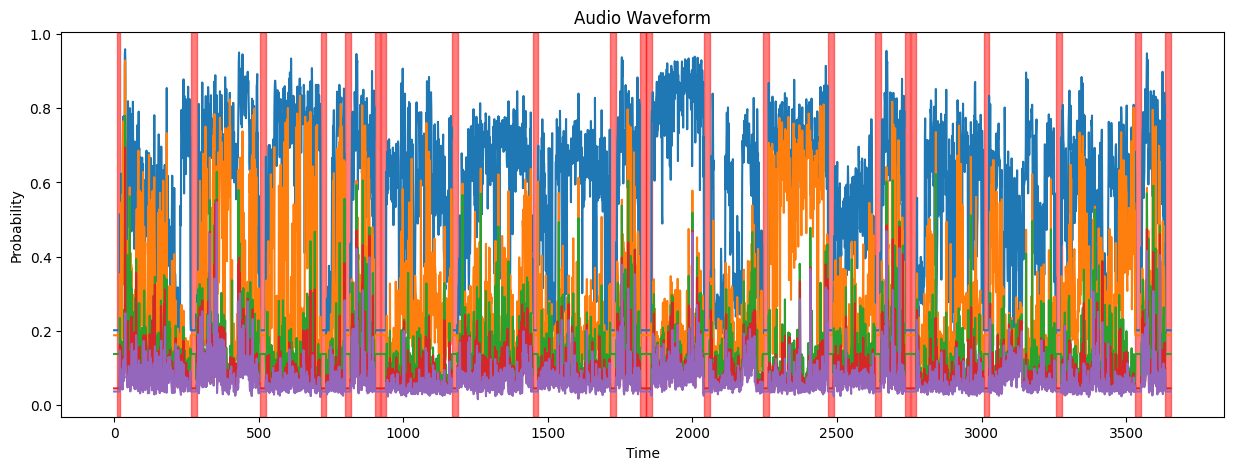

In [13]:
# plot probs_keep_all
plt.figure(figsize=(15, 5))
plt.plot(np.array(probs_keep_all)[:,:])
# plt.plot(np.max(probs_keep, axis=1))
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Probability")
# Higlight fixation points
for i in range(0,len(fixation),2):
    plt.axvspan(fixation[i], fixation[i+1], color='red', alpha=0.5)
plt.show()

In [14]:
top5_names_all[0]

[]

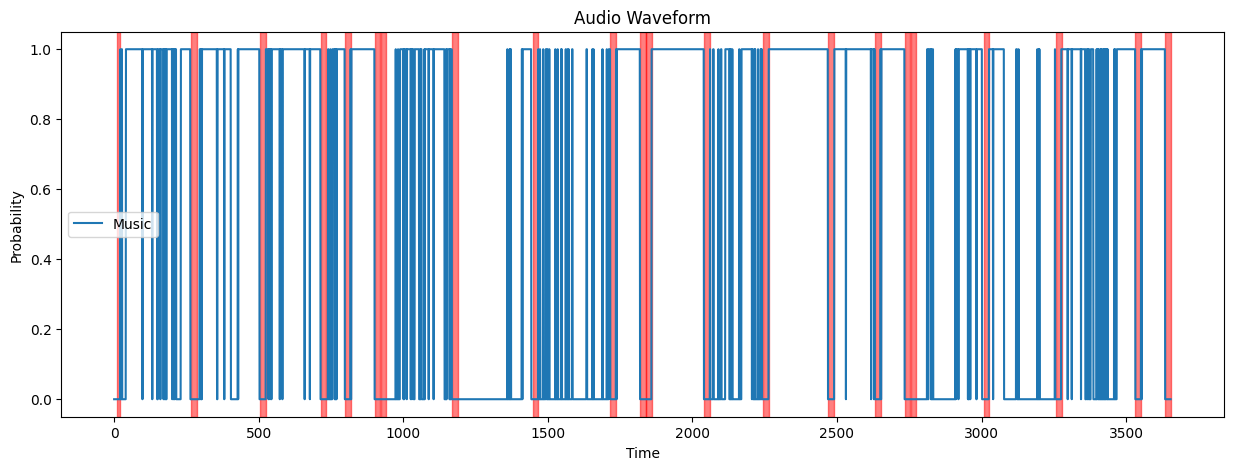

In [15]:
# plot probs_keep_all
plt.figure(figsize=(15, 5))
plt.plot([['Music'] in item for item in top5_names_all])
# plt.plot([['Speech'] in item for item in top5_names_all])
# plt.plot(np.max(probs_keep, axis=1))
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend(['Music', 'Speech'])
# Higlight fixation points
for i in range(0,len(fixation),2):
    plt.axvspan(fixation[i], fixation[i+1], color='red', alpha=0.5)
plt.show()

In [16]:
print(f"music/all: {sum([['Music'] in item for item in top5_names_all])/len(top5_names_all)}")
print(f"speech/all: {sum([['Speech'] in item for item in top5_names_all])/len(top5_names_all)}")

music/all: 0.5611491108071135
speech/all: 0.5436388508891928


In [17]:
# save regressor to .mat file
import scipy.io as sio
probs_keep_all = np.array(probs_keep_all)
sio.savemat('probs_keep_all.mat', {'probs_keep_all': probs_keep_all})

In [21]:
# Convert top5_names_all to a cell structure for matlab
top5_names_all_cell = []
for item in top5_names_all:
    # print(item)
    if len(item) == 0:
        top5_names_all_cell.append(np.array('', dtype=object))
    else:
        top5_names_all_cell.append(np.array(item))
top5_names_all_cell = np.array(top5_names_all_cell, dtype=object)
sio.savemat('top5_names_all_cell.mat', {'top5_names_all_cell': top5_names_all_cell})

In [22]:
for i in top5_names_all_cell:
    print(i)





















[['Insect']
 ['Cricket']]
[['Insect']]
[['Music']]

[['Insect']
 ['Cricket']]
[['Insect']
 ['Cricket']]
[['Insect']]
[['Music']]
[['Insect']
 ['Cricket']]
[['Insect']
 ['Cricket']]
[['Cricket']
 ['Insect']]
[['Cricket']
 ['Insect']]
[['Insect']
 ['Cricket']]
[['Cricket']
 ['Insect']]
[['Cricket']
 ['Insect']]
[['Insect']
 ['Cricket']
 ['Environmental noise']]
[['Insect']
 ['Cricket']]
[['Cricket']
 ['Insect']
 ['Fly, housefly']]
[['Insect']
 ['Cricket']
 ['Fly, housefly']
 ['Mosquito']]
[['Insect']
 ['Cricket']
 ['Fly, housefly']
 ['Bee, wasp, etc.']]
[['Insect']
 ['Cricket']]
[['Music']]
[['Music']]
[['Cricket']
 ['Music']
 ['Insect']]
[['Music']]
[['Music']]
[['Music']
 ['Insect']
 ['Cricket']]
[['Music']
 ['Singing bowl']]
[['Music']
 ['Sonar']]
[['Music']]
[['Music']]
[['Music']]
[['Music']]
[['Music']]
[['Music']
 ['Cricket']
 ['Insect']]
[['Music']]
[['Music']
 ['Insect']]
[['Music']
 ['Insect']
 ['Cricket']]
[['Music']]
[['Music']
 ['Insect']]
[['Insect']
 ['

## Merge Subtitles

In [ ]:
# Metge subtitles
file_names = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']

with open('subtitle.srt', 'w') as f:
    for file_name in file_names:
        with open(f'{file_name}.srt', 'r') as f2:
            for line in f2:
                f.write(line)
        f.write('\n')
f.close()

# Feature Extraction on Movie

In [3]:
#only run once
import os
os.system("ffmpeg -i movie.mp4 -ar 16000 -ac 1 rest_audio.wav")


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-2)
  configuration: --prefix=/opt/conda/envs/pytorch-dev --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1743376049581/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1743376049581/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1743376049581/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1743376049581/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-alsa --enable-libpulse --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame -

0

In [3]:
waveform, sample_rate = torchaudio.load("rest_audio.wav")
# Resample if the sampling rate is not 16kHz
if sample_rate != 16000:
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000) #beats uses 16khz sampling rate
    waveform = resample_transform(waveform)

# Convert to mono if necessary
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True) #1 channel

In [4]:
print(waveform.shape, sample_rate)

torch.Size([1, 58480478]) 16000


In [5]:
#padding_mask = torch.zeros(waveform.shape).bool()#no padding mask
import torchaudio
import json
from tqdm import tqdm

chunk_samples = 16000*10 #10 second chunks -> run beats on each chunk individually to not crash
if sample_rate != 16000:
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resample_transform(waveform)

if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
    
device = torch.device("cuda")
BEATs_tokenizer = BEATs_tokenizer.to(device)
BEATs_model = BEATs_model.to(device)


labels = []
features = []
num_chunks = waveform.shape[1]//chunk_samples
BEATs_tokenizer.eval()
BEATs_model.eval()
with torch.no_grad():
    for start in tqdm(range(0, waveform.shape[1], chunk_samples), total=num_chunks):
        end = min(start + chunk_samples, waveform.shape[1])
        chunk = waveform[:, start:end]
        if chunk.shape[1] < chunk_samples:
            padding = torch.zeros(1, chunk_samples - chunk.shape[1], device=chunk.device)
            chunk = torch.cat((chunk, padding), dim=1)#zero padding if chunk too short
        chunk = chunk.to(device)
        labels_chunk = BEATs_tokenizer.extract_labels(chunk)
        labels.append(labels_chunk)
        features_chunk = BEATs_model.extract_features(chunk)[0]#(batch, num frames, frame dim)
        features.append(features_chunk.cpu().squeeze(0)) 

labels = torch.cat(labels, dim=0) #(token ids, )
features = torch.cat(features, dim=0)#(total frames, frame dim)

total_audio_dur = waveform.shape[1]/16000#num samples / sample rate
frame_rate = int(features.shape[0]/total_audio_dur)
print(frame_rate)

features_per_sec = []
for t in range(1, 3656):
    start = (t-1)*frame_rate #t-1 to t features
    end = t*frame_rate
    if end <= features.shape[0]:
        window = features[start:end]
        features_per_sec.append(window.mean(dim=0))#brain data 1 per sec -> 49 frames per sec feature vectors -> avg 49 feature vectors

features_per_sec = torch.stack(features_per_sec) #(time dim 3655, frame dim -> num features)
print(features_per_sec.shape)#use these features for mapping
print(features_per_sec)
print(labels.shape)
print(labels) #print raw token ids
print(features.shape)
print(features)#each row is frame
print(features[0].shape)

366it [00:30, 11.84it/s]                                                        


49
torch.Size([3655, 768])
tensor([[ 0.0696,  0.2462,  0.1349,  ..., -0.0813,  0.1909,  0.6636],
        [ 0.0677,  0.2605,  0.0886,  ..., -0.0841,  0.1483,  0.6823],
        [ 0.0694,  0.2611,  0.0806,  ..., -0.0768,  0.1394,  0.6835],
        ...,
        [-0.0562, -0.3268,  0.2028,  ..., -0.1101,  0.1889, -0.1629],
        [ 0.1319, -0.2553, -0.0234,  ...,  0.0813,  0.0953, -0.3228],
        [ 0.1637, -0.3280, -0.0656,  ...,  0.0031,  0.0969, -0.0165]])
torch.Size([181536])
tensor([531, 531, 531,  ..., 531, 531,  72], device='cuda:0')
torch.Size([181536, 768])
tensor([[ 0.0450,  0.0229,  0.1287,  ..., -0.0172,  0.2426,  0.5934],
        [ 0.0482,  0.0538,  0.1354,  ..., -0.0592,  0.2509,  0.5828],
        [ 0.0633,  0.2322,  0.1627,  ..., -0.1425,  0.2460,  0.6410],
        ...,
        [ 0.1221,  0.2342,  0.1788,  ..., -0.1903,  0.2882,  0.6437],
        [ 0.2168,  0.1204,  0.2047,  ..., -0.1619,  0.2731,  0.5740],
        [ 0.2262,  0.0918,  0.1943,  ..., -0.1605,  0.2619,  0.5684

In [7]:
features_chunk = BEATs_model.extract_features(chunk)[0]
print(features_chunk.shape) #(batch size, num frames, frame dimension)

torch.Size([1, 496, 768])


In [ ]:
from scipy.io import savemat

features_per_sec_mat = features_per_sec.cpu().numpy()
savemat("features_per_sec.mat", {"features_per_sec": features_per_sec_mat})